In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

##Data Processing

CO2 Concentration

In [ ]:
co2_df = pd.read_csv("/content/drive/MyDrive/Classroom/Time Series/Dataset/co2_mm_gl.csv")

co2_df = co2_df[['year', 'month', 'average']]
co2_df['day'] = 1

co2_df['date'] = pd.to_datetime(co2_df[['year', 'month', 'day']])
co2_df = co2_df.set_index('date')

co2_df = co2_df.rename(columns={'average': 'co2_ppm'})
co2_df = co2_df[['co2_ppm']]

SOI

In [ ]:
soi_df = pd.read_excel("/content/drive/MyDrive/Classroom/Time Series/Dataset/SOI_dataset.xlsx")

soi_df = soi_df[['year', 'month', 'soi']]
soi_df['day'] = 1

soi_df['date'] = pd.to_datetime(soi_df[['year', 'month', 'day']])
soi_df = soi_df.set_index('date')
soi_df = soi_df[['soi']]
soi_df['soi'] = pd.to_numeric(soi_df['soi'], errors='coerce')

Combine Data

In [ ]:
all_data = pd.concat([co2_df, soi_df], axis=1, join='inner')
all_data.head()
all_data.isnull().sum()

,0
co2_ppm,0
soi,0


Visualization Data

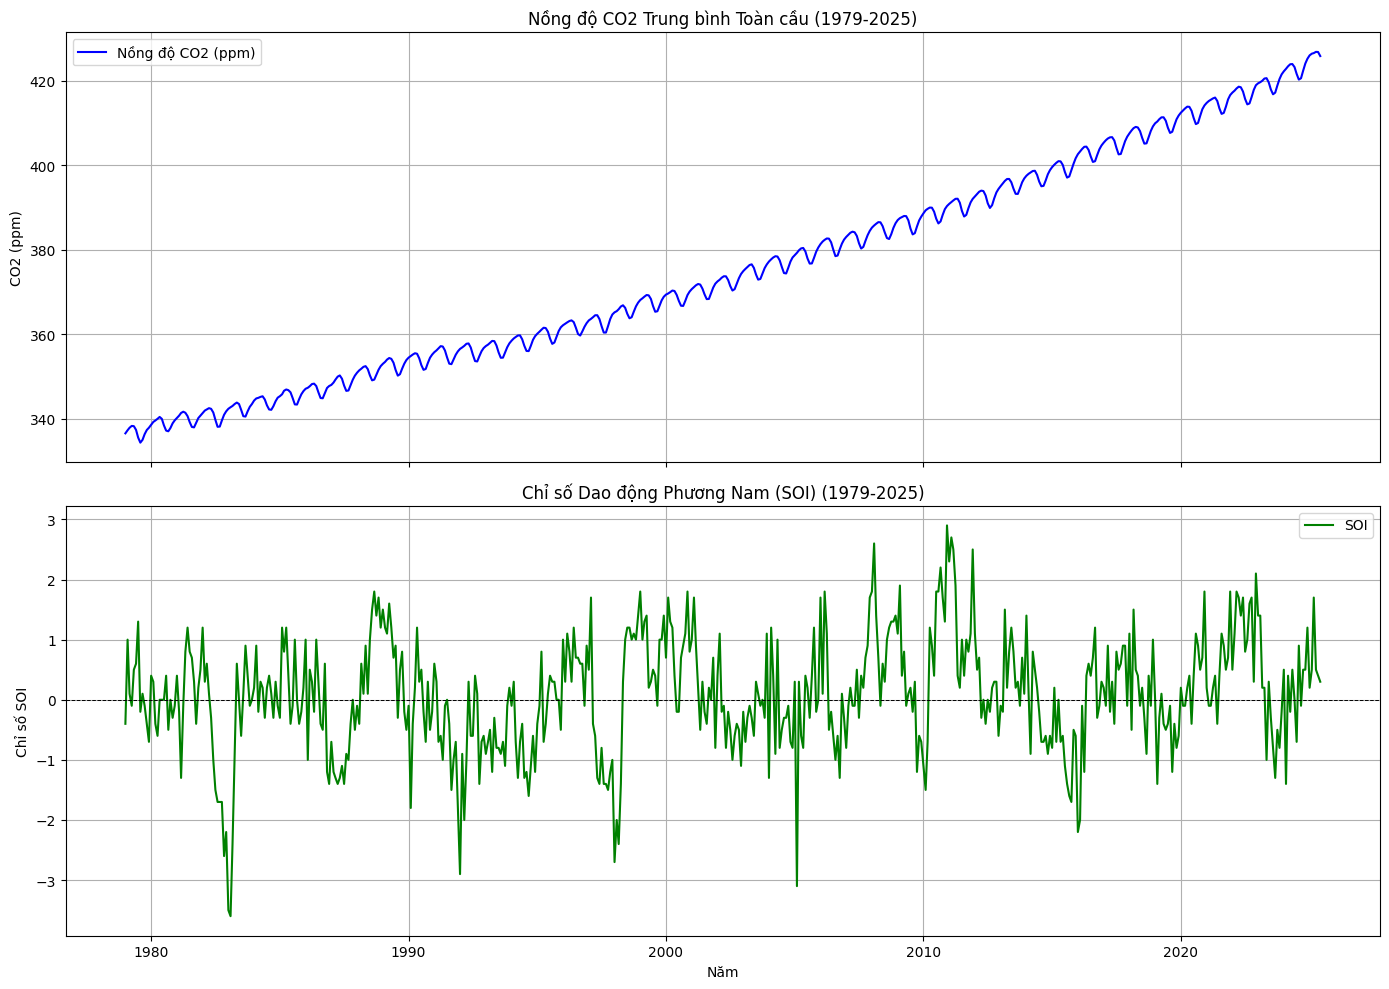

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(all_data.index, all_data['co2_ppm'], label='Nồng độ CO2 (ppm)', color='b')
ax1.set_ylabel('CO2 (ppm)')
ax1.set_title('Nồng độ CO2 Trung bình Toàn cầu (1979-2025)')
ax1.legend()
ax1.grid(True)

ax2.plot(all_data.index, all_data['soi'], label='SOI', color='g')
ax2.set_ylabel('Chỉ số SOI')
ax2.set_title('Chỉ số Dao động Phương Nam (SOI) (1979-2025)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.7)
ax2.legend()
ax2.grid(True)

plt.xlabel('Năm')
plt.tight_layout()
plt.show()

##Baseline Models

Model evaluation function

In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"--- Đánh giá {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE:  {mape:.4f}")
    return mse, rmse, mae, mape

Function plot the result chart

In [ ]:
def plot_results(train_data, test_data, predictions, model_name):
    plt.figure(figsize=(15, 7))
    plt.plot(train_data.index, train_data, label='Dữ liệu Training')
    plt.plot(test_data.index, test_data, label='Dữ liệu Testing', color='orange')
    plt.plot(predictions.index, predictions, label=f'Dự đoán {model_name}', color='green', linestyle='--')
    plt.title(f'Dự đoán nồng độ CO2 - Mô hình {model_name}')
    plt.xlabel('Ngày')
    plt.ylabel('Nồng độ CO2 (ppm)')
    plt.legend()
    plt.grid(True)
    plt.show()

##SARIMA vs SARIMAX

Tính dừng

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("\nKiểm tra tính dừng (ADF Test)")
adf_result = adfuller(all_data['co2_ppm'])
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
if adf_result[1] <= 0.05:
    print("=> Chuỗi thời gian là dừng.")
else:
    print("=> Chuỗi thời gian không dừng. Cần thực hiện sai phân.")


Kiểm tra tính dừng (ADF Test)
ADF Statistic: 4.6215
p-value: 1.0000
=> Chuỗi thời gian không dừng. Cần thực hiện sai phân.


In [ ]:
data_diff_1 = all_data['co2_ppm'].diff(1).dropna()
print("\nKiểm tra tính dừng sau khi sai phân bậc 1")
adf_result = adfuller(data_diff_1)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
if adf_result[1] <= 0.05:
    print("=> Chuỗi thời gian là dừng.")
else:
    print("=> Chuỗi thời gian không dừng. Cần thực hiện sai phân.")


Kiểm tra tính dừng sau khi sai phân bậc 1
ADF Statistic: -5.1457
p-value: 0.0000
=> Chuỗi thời gian là dừng.


ACF vs PACF

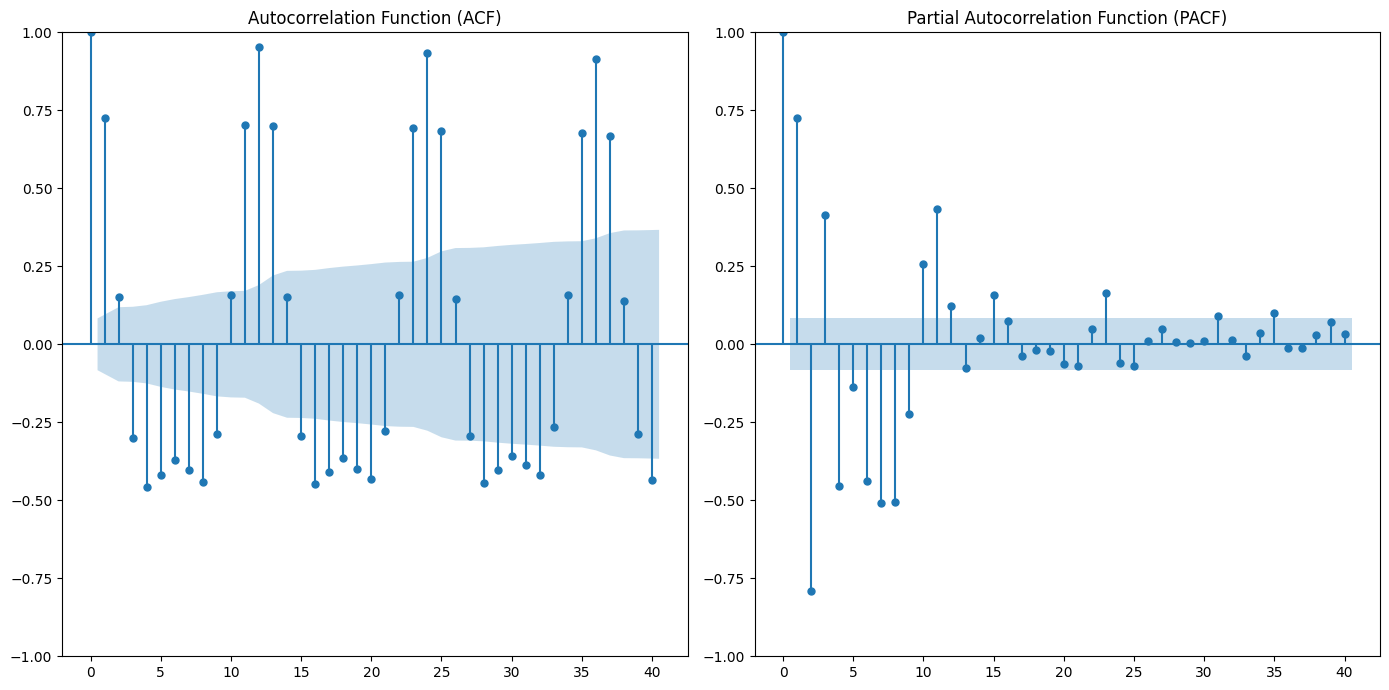

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(data_diff_1, lags=40, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.subplot(122)
plot_pacf(data_diff_1, lags=40, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

Dựa vào ACF thấy chuỗi có tính mùa không dừng nên cần sai phân

In [ ]:
data_diff_final = data_diff_1.diff(12).dropna()
adf_final = adfuller(data_diff_final)
print(f'ADF Statistic: {adf_final[0]:.4f}')
print(f'p-value: {adf_final[1]:.4f}')
if adf_final[1] <= 0.05:
    print("Chuỗi ĐÃ DỪNG HOÀN TOÀN. Sẵn sàng tìm p,q,P,Q.")
else:
    print("Chuỗi chưa dừng.")

ADF Statistic: -8.8739
p-value: 0.0000
Chuỗi ĐÃ DỪNG HOÀN TOÀN. Sẵn sàng tìm p,q,P,Q.


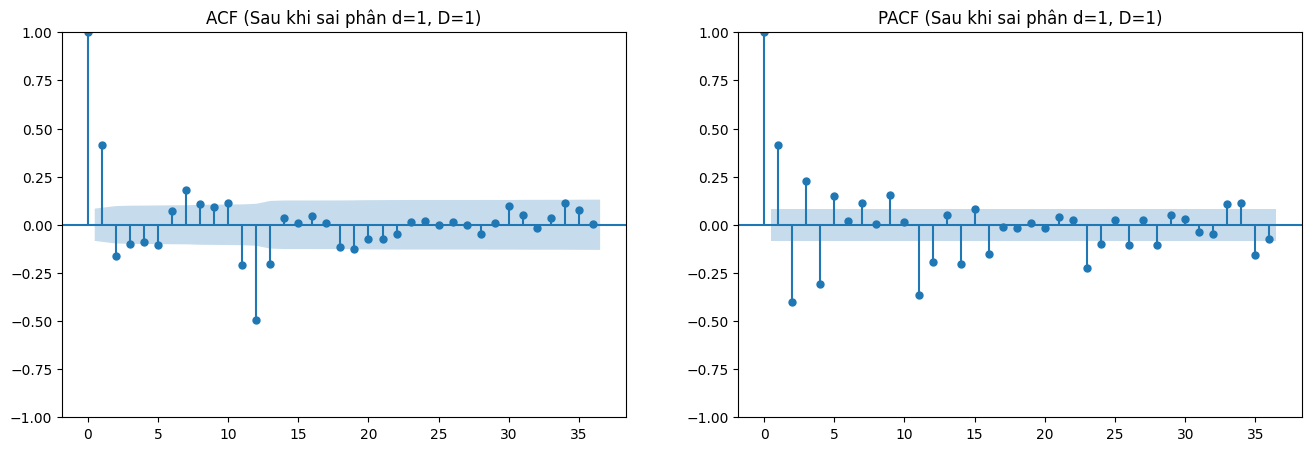

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# lags nên lớn hơn 1 chu kỳ mùa (ví dụ: 36)
plot_acf(data_diff_final, lags=36, ax=axes[0])
axes[0].set_title('ACF (Sau khi sai phân d=1, D=1)')

plot_pacf(data_diff_final, lags=36, ax=axes[1])
axes[1].set_title('PACF (Sau khi sai phân d=1, D=1)')

plt.show()

In [ ]:
test_size = 447
train_co2 = co2_df[:test_size]
test_co2 = co2_df[test_size:]

train_soi = soi_df[:test_size]
test_soi = soi_df[test_size:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
def manual_sarima_grid_search(y_train, exog_train, d, D, m=12):
    p = [0,1,2,3,4]
    q = [0,1,2,3]
    P = [0,1,2]
    Q = [0,1]
    d = 1
    D = 1

    param_combinations = list(itertools.product(p, q, P, Q))
    results = []
    best_aic = np.inf
    best_model_params = {}

    for (p, q, P, Q) in param_combinations:
        order = (p, d, q)
        seasonal_order = (P, D, Q, m)

        try:
            model = SARIMAX(
                y_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            fit = model.fit(disp=False)

            aic = fit.aic
            bic = fit.bic

            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'AIC': aic,
                'BIC (SIC)': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model_params = {
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'AIC': aic,
                    'BIC (SIC)': bic
                }

        except Exception as e:
            continue

    results_df = pd.DataFrame(results).sort_values(by='AIC').reset_index(drop=True)

    return best_model_params, results_df

In [ ]:
best_sarima_params, sarima_results_df = manual_sarima_grid_search(
    y_train=train_co2['co2_ppm'],
    exog_train=None,
    d=1,
    D=1,
    m=12
)

print("\nTop 5 mô hình SARIMA tốt nhất (theo AIC):")
print(sarima_results_df.head())
print("\nMô hình SARIMA tốt nhất được chọn:")
print(best_sarima_params)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


Top 5 mô hình SARIMA tốt nhất (theo AIC):
       order seasonal_order         AIC   BIC (SIC)
0  (4, 1, 3)  (1, 1, 1, 12) -603.576596 -563.221782
1  (4, 1, 1)  (1, 1, 1, 12) -603.103334 -570.819483
2  (4, 1, 3)  (0, 1, 1, 12) -602.731012 -566.411679
3  (0, 1, 3)  (1, 1, 1, 12) -601.447159 -577.234271
4  (4, 1, 2)  (1, 1, 1, 12) -601.303224 -564.983891

Mô hình SARIMA tốt nhất được chọn:
{'order': (4, 1, 3), 'seasonal_order': (1, 1, 1, 12), 'AIC': np.float64(-603.5765958928191), 'BIC (SIC)': np.float64(-563.2217815675715)}


In [ ]:
best_sarimax_params, sarimax_results_df = manual_sarima_grid_search(
    y_train=train_co2['co2_ppm'],
    exog_train=train_soi['soi'],
    d=1,
    D=1,
    m=12
)

print("\nTop 5 mô hình SARIMAX tốt nhất (theo AIC):")
print(sarimax_results_df.head())
print("\nMô hình SARIMAX tốt nhất được chọn:")
print(best_sarimax_params)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


Top 5 mô hình SARIMAX tốt nhất (theo AIC):
       order seasonal_order         AIC   BIC (SIC)
0  (4, 1, 3)  (1, 1, 1, 12) -602.372976 -557.982680
1  (4, 1, 1)  (1, 1, 1, 12) -602.211574 -565.892241
2  (0, 1, 3)  (1, 1, 1, 12) -600.678285 -572.429915
3  (4, 1, 3)  (0, 1, 1, 12) -600.557506 -560.202691
4  (0, 1, 3)  (0, 1, 1, 12) -600.287646 -576.074758

Mô hình SARIMAX tốt nhất được chọn:
{'order': (4, 1, 3), 'seasonal_order': (1, 1, 1, 12), 'AIC': np.float64(-602.3729755780478), 'BIC (SIC)': np.float64(-557.9826798202755)}



--- HUẤN LUYỆN VÀ ĐÁNH GIÁ SARIMA TỐT NHẤT ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--- Đánh giá SARIMA (Best Manual) ---
MSE: 0.9855
RMSE:  0.9927
MAE:  0.7538
MAPE:  0.1803


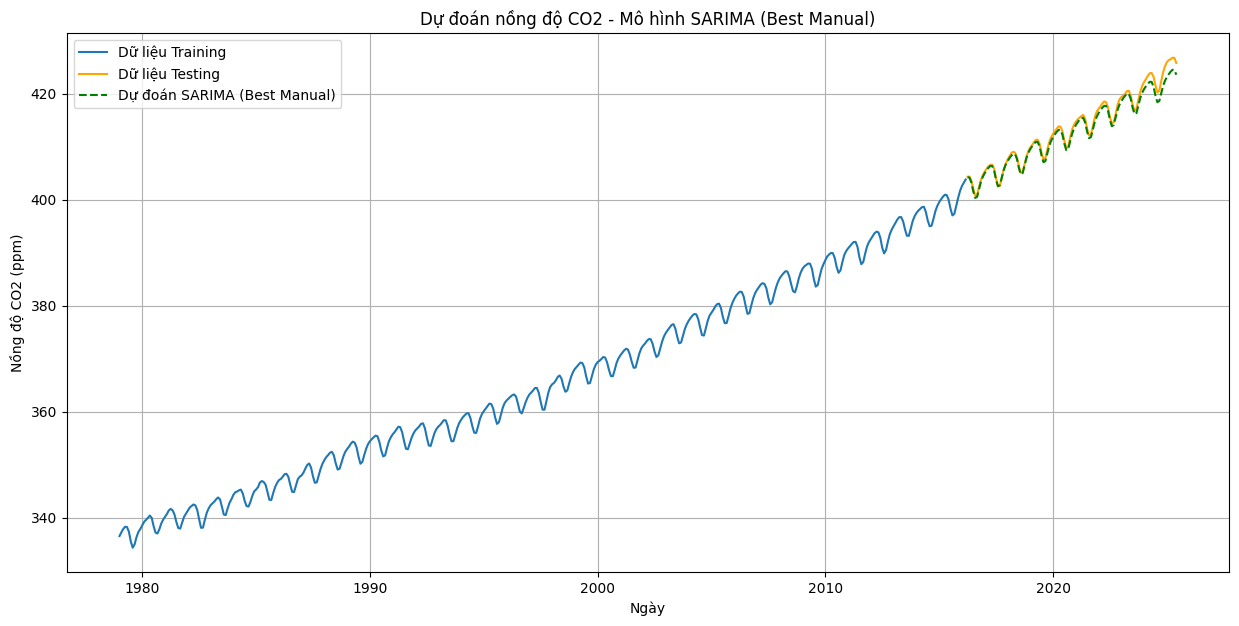

In [ ]:
print("\n--- HUẤN LUYỆN VÀ ĐÁNH GIÁ SARIMA TỐT NHẤT ---")
best_sarima_model = SARIMA(
    train_co2['co2_ppm'],
    order=best_sarima_params['order'],
    seasonal_order=best_sarima_params['seasonal_order']
)
best_sarima_fit = best_sarima_model.fit(disp=False)

sarima_preds = best_sarima_fit.predict(
    start=test_co2.index[0],
    end=test_co2.index[-1]
)

mse_sarima, rmse_sarima, mae_sarima, mape_sarima = evaluate_model(test_co2, sarima_preds, "SARIMA (Best Manual)")
plot_results(train_co2, test_co2, sarima_preds, "SARIMA (Best Manual)")


--- HUẤN LUYỆN VÀ ĐÁNH GIÁ SARIMAX TỐT NHẤT ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--- Đánh giá SARIMAX (Best Manual) ---
MSE: 1.0816
RMSE:  1.0400
MAE:  0.7997
MAPE:  0.1913


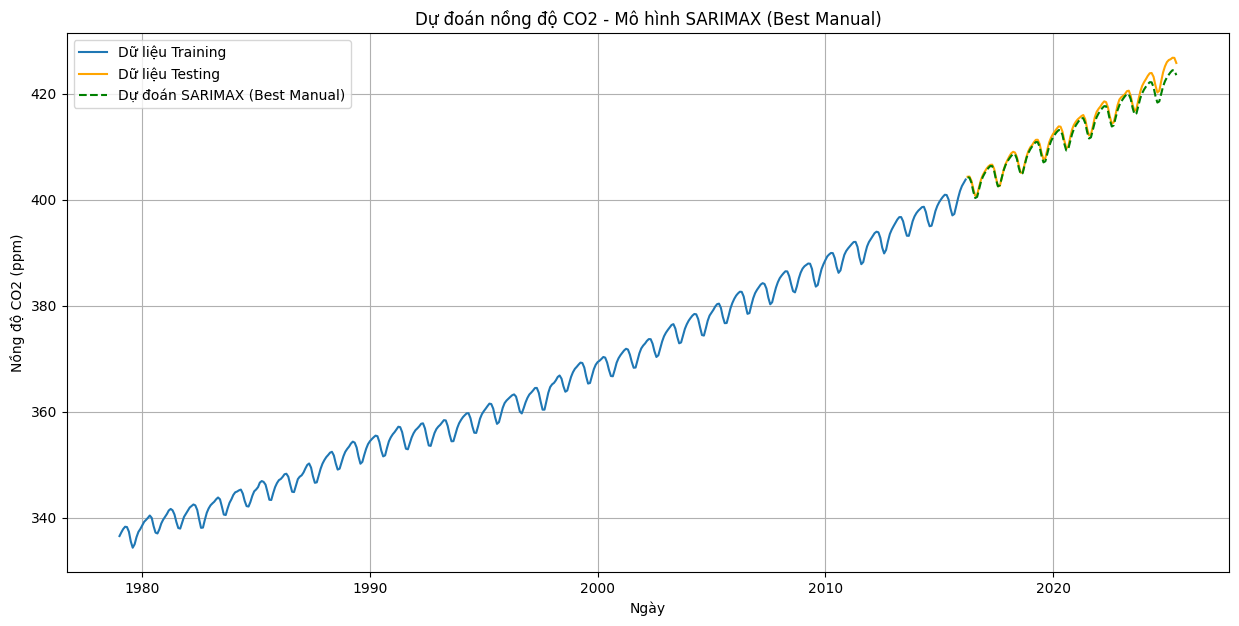

In [ ]:
print("\n--- HUẤN LUYỆN VÀ ĐÁNH GIÁ SARIMAX TỐT NHẤT ---")
best_sarimax_model = SARIMAX(
    train_co2['co2_ppm'],
    exog=train_soi['soi'],
    order=best_sarimax_params['order'],
    seasonal_order=best_sarimax_params['seasonal_order']
)
best_sarimax_fit = best_sarimax_model.fit(disp=False)

sarimax_preds = best_sarimax_fit.predict(
    start=test_co2.index[0],
    end=test_co2.index[-1],
    exog=test_soi['soi']
)

mse_sarimax, rmse_sarimax, mae_sarimax, mape_sarimax = evaluate_model(test_co2, sarimax_preds, "SARIMAX (Best Manual)")
plot_results(train_co2, test_co2, sarimax_preds, "SARIMAX (Best Manual)")

LSTM single vs LSTM multiple

In [ ]:
!pip install optuna

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna

def create_sequences(data_x, data_y, timesteps):
    X, y = [], []
    for i in range(len(data_x) - timesteps):
        X.append(data_x[i:(i + timesteps)])
        y.append(data_y[i + timesteps])
    return np.array(X), np.array(y)

def create_model(trial_params, input_shape):
    n_layers = trial_params.get('n_layers', 1)
    n_units = trial_params.get('n_units', 64)
    dropout_rate = trial_params.get('dropout', 0.1)
    learning_rate = trial_params.get('learning_rate', 0.001)

    model = Sequential()

    for i in range(n_layers):
        if i == 0:
            model.add(LSTM(n_units, return_sequences=(n_layers > 1), input_shape=input_shape))
        else:
            model.add(LSTM(n_units, return_sequences=(i < n_layers - 1)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

def objective(trial, train_x, train_y, val_x, val_y):
    timesteps = trial.suggest_int('timesteps', 12, 48)
    params = {
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'n_units': trial.suggest_int('n_units', 64, 128, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'timesteps': timesteps
    }

    X_train, y_train = create_sequences(train_x, train_y, timesteps)
    X_val, y_val = create_sequences(val_x, val_y, timesteps)

    if len(X_train) == 0 or len(X_val) == 0:
        return np.inf

    if train_x.ndim == 1:
        n_features = 1
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    else:
        n_features = train_x.shape[1]

    model = create_model(params, input_shape=(timesteps, n_features))

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=0,
        batch_size=32
    )

    return np.min(history.history['val_loss'])

In [ ]:
import numpy as np

def recursive_forecast(model, train_data, n_steps, test_exog=None):
    timesteps = model.input_shape[1]
    n_features = model.input_shape[2]

    predictions = []

    if n_features == 1 and train_data.ndim == 1:
        train_data = train_data.reshape(-1, 1)

    last_window = train_data[-timesteps:].reshape(1, timesteps, n_features)

    current_window = last_window.copy()

    for i in range(n_steps):
        pred_scaled = model.predict(current_window, verbose=0)[0][0]
        predictions.append(pred_scaled)
        current_window = np.roll(current_window, -1, axis=1)
        if n_features == 1:
            current_window[0, -1, 0] = pred_scaled
        else:
            current_window[0, -1, 0] = pred_scaled
            current_window[0, -1, 1:] = test_exog[i]

    return np.array(predictions)

In [ ]:
import numpy as np

def add_seasonal_features(df):
    df_new = df.copy()


    df_new['month'] = df_new.index.month

    df_new['month_sin'] = np.sin(2 * np.pi * df_new['month'] / 12.0)
    df_new['month_cos'] = np.cos(2 * np.pi * df_new['month'] / 12.0)

    df_new = df_new.drop('month', axis=1)
    return df_new

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

all_data_featured = add_seasonal_features(all_data)
all_data_featured['trend'] = np.arange(len(all_data_featured))

train_rows = 447
train_df = all_data_featured.iloc[:train_rows]
test_df = all_data_featured.iloc[train_rows:]

degree = 3
lr_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

lr_model.fit(train_df[['trend']], train_df['co2_ppm'])

all_data_featured['trend_fit'] = lr_model.predict(all_data_featured[['trend']])

all_data_featured['co2_detrended'] = all_data_featured['co2_ppm'] - all_data_featured['trend_fit']

lstm_cols = ['co2_detrended', 'soi', 'month_sin', 'month_cos']
lstm_data = all_data_featured[lstm_cols]

train_lstm_data = lstm_data.iloc[:train_rows]
test_lstm_data = lstm_data.iloc[train_rows:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_lstm_data)
test_scaled = scaler.transform(test_lstm_data)

val_split = int(len(train_scaled) * 0.8)

y_train_full_scaled = train_scaled[:, 0]
multi_train_y = y_train_full_scaled[:val_split]
multi_val_y = y_train_full_scaled[val_split:]
uni_train_y = y_train_full_scaled[:val_split]
uni_val_y = y_train_full_scaled[val_split:]

multi_train_x = train_scaled[:val_split]
multi_val_x = train_scaled[val_split:]

uni_cols_indices = [0, 2, 3]
uni_train_x = train_scaled[:val_split][:, uni_cols_indices]
uni_val_x = train_scaled[val_split:][:, uni_cols_indices]

In [ ]:
N_TRIALS = 100

print("--- Bắt đầu Tối ưu hóa LSTM Đơn biến ---")
study_uni = optuna.create_study(direction='minimize')

study_uni.optimize(
    lambda trial: objective(
        trial,
        uni_train,
        uni_train,
        uni_val,
        uni_val
    ),
    n_trials=N_TRIALS
)

best_params_uni = study_uni.best_params
print("\nSiêu tham số tốt nhất cho LSTM Đơn biến:")
print(best_params_uni)

print("\n--- Bắt đầu Tối ưu hóa LSTM Đa biến ---")
study_multi = optuna.create_study(direction='minimize')

study_multi.optimize(
    lambda trial: objective(
        trial,
        multi_train_x,
        multi_train_y,
        multi_val_x,
        multi_val_y
    ),
    n_trials=N_TRIALS
)

best_params_multi = study_multi.best_params
print("\nSiêu tham số tốt nhất cho LSTM Đa biến:")
print(best_params_multi)

[I 2025-11-06 08:53:45,665] A new study created in memory with name: no-name-c737f410-9bb0-4a94-b761-2a1dee42d1c4


--- Bắt đầu Tối ưu hóa LSTM Đơn biến ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-11-06 08:55:06,961] Trial 0 finished with value: 0.0708557665348053 and parameters: {'timesteps': 46, 'n_layers': 3, 'n_units': 65, 'dropout': 0.14639490280650547, 'learning_rate': 0.00018757426282035454}. Best is trial 0 with value: 0.0708557665348053.
[I 2025-11-06 08:55:35,478] Trial 1 finished with value: 0.03945412114262581 and parameters: {'timesteps': 43, 'n_layers': 2, 'n_units': 85, 'dropout': 0.3442854877602022, 'learning_rate': 0.0005632032735083963}. Best is trial 1 with value: 0.03945412114262581.
[I 2025-11-06 08:56:25,861] Trial 2 finished with value: 0.020992128178477287 and parameters: {'timesteps': 32, 'n_layers': 2, 'n_units': 106, 'dropout': 0.28660086854747047, 'learning_rate'


Siêu tham số tốt nhất cho LSTM Đơn biến:
{'timesteps': 43, 'n_layers': 2, 'n_units': 117, 'dropout': 0.12112287103743995, 'learning_rate': 0.00922635155603257}

--- Bắt đầu Tối ưu hóa LSTM Đa biến ---


[I 2025-11-06 10:14:11,090] Trial 0 finished with value: 0.04095768183469772 and parameters: {'timesteps': 19, 'n_layers': 3, 'n_units': 65, 'dropout': 0.17908798413417432, 'learning_rate': 0.003110532019750889}. Best is trial 0 with value: 0.04095768183469772.
[I 2025-11-06 10:14:16,545] Trial 1 finished with value: 0.026613106951117516 and parameters: {'timesteps': 16, 'n_layers': 1, 'n_units': 81, 'dropout': 0.21092037560430565, 'learning_rate': 0.0013453100760492422}. Best is trial 1 with value: 0.026613106951117516.
[I 2025-11-06 10:14:33,088] Trial 2 finished with value: 0.02635711058974266 and parameters: {'timesteps': 14, 'n_layers': 3, 'n_units': 112, 'dropout': 0.2647584931898023, 'learning_rate': 0.005953069774331759}. Best is trial 2 with value: 0.02635711058974266.
[I 2025-11-06 10:15:05,653] Trial 3 finished with value: 0.017561329528689384 and parameters: {'timesteps': 25, 'n_layers': 3, 'n_units': 113, 'dropout': 0.2965172918633826, 'learning_rate': 0.008248537863933446


Siêu tham số tốt nhất cho LSTM Đa biến:
{'timesteps': 40, 'n_layers': 1, 'n_units': 108, 'dropout': 0.18889512031092912, 'learning_rate': 0.00978931309517444}


In [ ]:
print("\n--- Huấn luyện mô hình Đơn biến Tốt nhất ---")
timesteps_uni = best_params_uni['timesteps']

X_train_uni, y_train_uni = create_sequences(y_train_full_scaled, y_train_full_scaled, timesteps_uni)
X_train_uni = X_train_uni.reshape((X_train_uni.shape[0], X_train_uni.shape[1], 1))

model_uni = create_model(best_params_uni, input_shape=(timesteps_uni, 1))
model_uni.fit(
    X_train_uni, y_train_uni,
    epochs=100,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)],
    verbose=1,
    batch_size=32
)

print("\n--- Thực hiện Dự đoán Đệ quy Đơn biến ---")
n_steps_forecast = len(test_scaled)

predictions_scaled_uni = recursive_forecast(
    model_uni,
    y_train_full_scaled,
    n_steps=n_steps_forecast,
    test_exog=None
)
dummy_inverse_uni = np.zeros((n_steps_forecast, 4))
dummy_inverse_uni[:, 0] = predictions_scaled_uni
ziczac_forecast_uni = scaler.inverse_transform(dummy_inverse_uni)[:, 0]

trend_forecast = all_data_featured['trend_fit'].iloc[train_rows:].values
predictions_uni_final = ziczac_forecast_uni + trend_forecast


print("\n--- Huấn luyện mô hình Đa biến Tốt nhất (với 4 features) ---")
timesteps_multi = best_params_multi['timesteps']
n_features_multi = train_scaled.shape[1]

print(f"Huấn luyện mô hình đa biến với {n_features_multi} features.")

X_train_multi, y_train_multi = create_sequences(
    train_scaled,
    y_train_full_scaled,
    timesteps_multi
)

model_multi = create_model(best_params_multi, input_shape=(timesteps_multi, n_features_multi))
model_multi.fit(
    X_train_multi, y_train_multi,
    epochs=100,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)],
    verbose=1,
    batch_size=32
)

test_exog_data = test_scaled[:, 1:]
print(f"Shape của test_exog (L-OTI, sin, cos): {test_exog_data.shape}")

print("\n--- Thực hiện Dự đoán Đệ quy Đa biến ---")
predictions_scaled_multi = recursive_forecast(
    model_multi,
    train_scaled,
    n_steps=n_steps_forecast,
    test_exog=test_exog_data
)
final_predictions_scaled = np.zeros((n_steps_forecast, 4))
final_predictions_scaled[:, 0] = predictions_scaled_multi
final_predictions_scaled[:, 1:] = test_exog_data

final_predictions_unscaled = scaler.inverse_transform(final_predictions_scaled)
ziczac_forecast_multi = final_predictions_unscaled[:, 0]

predictions_multi_final = ziczac_forecast_multi + trend_forecast


--- Huấn luyện mô hình Đơn biến Tốt nhất ---
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - loss: 0.7463
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - loss: 0.1978
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0959
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0720
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - loss: 0.0496
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0443
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0372
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 0.0358
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - loss: 0.0468
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0520
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0439
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0410
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0265
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.032

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.5375
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0539
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0440
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0335
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0230
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0230
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0219
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0194
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0217
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0213
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0228
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0183
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0145
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0151
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0141
E


--- TỔNG KẾT SO SÁNH LSTM ---
LSTM Đơn biến (Optuna) | RMSE: 0.9407 | MSE: 0.8850 | MAE: 0.6840 | MAPE: 0.0016
LSTM Đa biến (4 Feat) | RMSE: 0.5513 | MSE: 0.3040 | MAE: 0.4415 | MAPE: 0.0011

==> Mô hình LSTM Đa biến cho kết quả dự đoán TỐT HƠN.


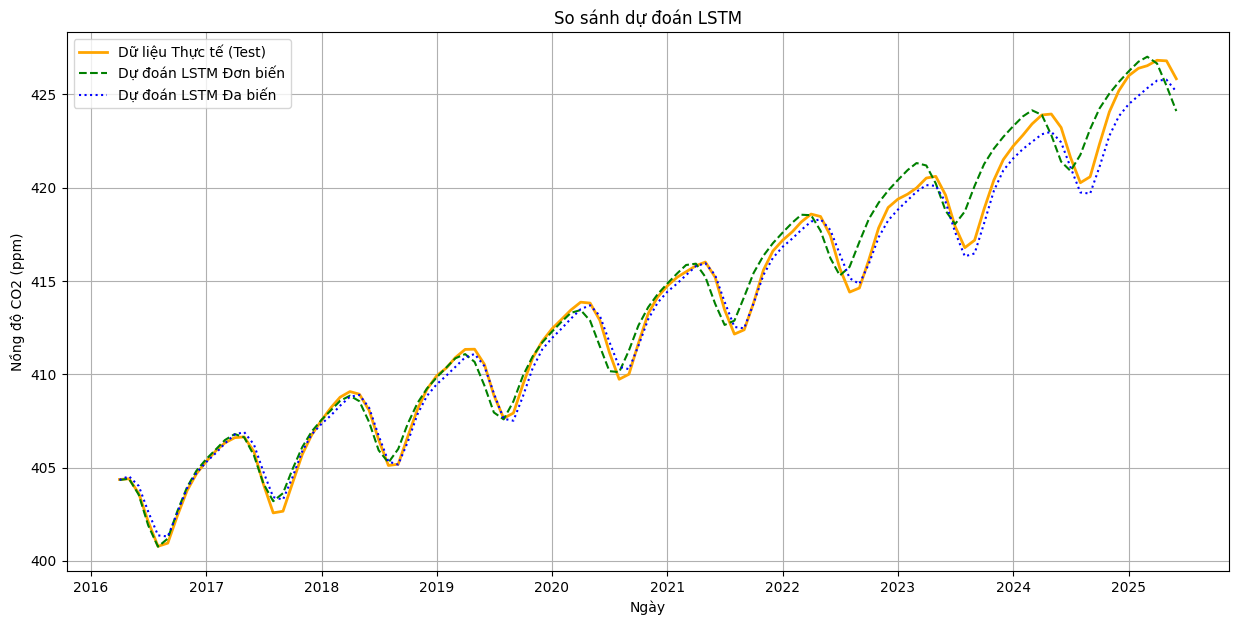

In [ ]:
rmse_uni = np.sqrt(mean_squared_error(test_df['co2_ppm'].values, predictions_uni_final))
mse_uni = mean_squared_error(test_df['co2_ppm'].values, predictions_uni_final)
mae_uni = mean_absolute_error(test_df['co2_ppm'].values, predictions_uni_final)
mape_uni = mean_absolute_percentage_error(test_df['co2_ppm'].values, predictions_uni_final)


rmse_multi = np.sqrt(mean_squared_error(test_df['co2_ppm'].values, predictions_multi_final))
mse_multi = mean_squared_error(test_df['co2_ppm'].values, predictions_multi_final)
mae_multi = mean_absolute_error(test_df['co2_ppm'].values, predictions_multi_final)
mape_multi = mean_absolute_percentage_error(test_df['co2_ppm'].values, predictions_multi_final)

print("\n--- TỔNG KẾT SO SÁNH LSTM ---")
print(f"LSTM Đơn biến (Optuna) | RMSE: {rmse_uni:.4f} | MSE: {mse_uni:.4f} | MAE: {mae_uni:.4f} | MAPE: {mape_uni:.4f}")
# Sửa tên:
print(f"LSTM Đa biến (4 Feat) | RMSE: {rmse_multi:.4f} | MSE: {mse_multi:.4f} | MAE: {mae_multi:.4f} | MAPE: {mape_multi:.4f}")

if rmse_multi < rmse_uni and mae_multi < mae_uni:
    # Sửa tên:
    print("\n==> Mô hình LSTM Đa biến cho kết quả dự đoán TỐT HƠN.")
else:
    # Sửa tên:
    print("\n==> Mô hình LSTM Đa biến KHÔNG cải thiện so với LSTM Đơn biến.")

plt.figure(figsize=(15, 7))
plt.plot(all_data.index[test_size:], test_df['co2_ppm'].values, label='Dữ liệu Thực tế (Test)', color='orange', linewidth=2)
plt.plot(all_data.index[test_size:], predictions_uni_final, label='Dự đoán LSTM Đơn biến', color='green', linestyle='--')
plt.plot(all_data.index[test_size:], predictions_multi_final, label='Dự đoán LSTM Đa biến', color='blue', linestyle=':')
plt.title('So sánh dự đoán LSTM')
plt.xlabel('Ngày')
plt.ylabel('Nồng độ CO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()

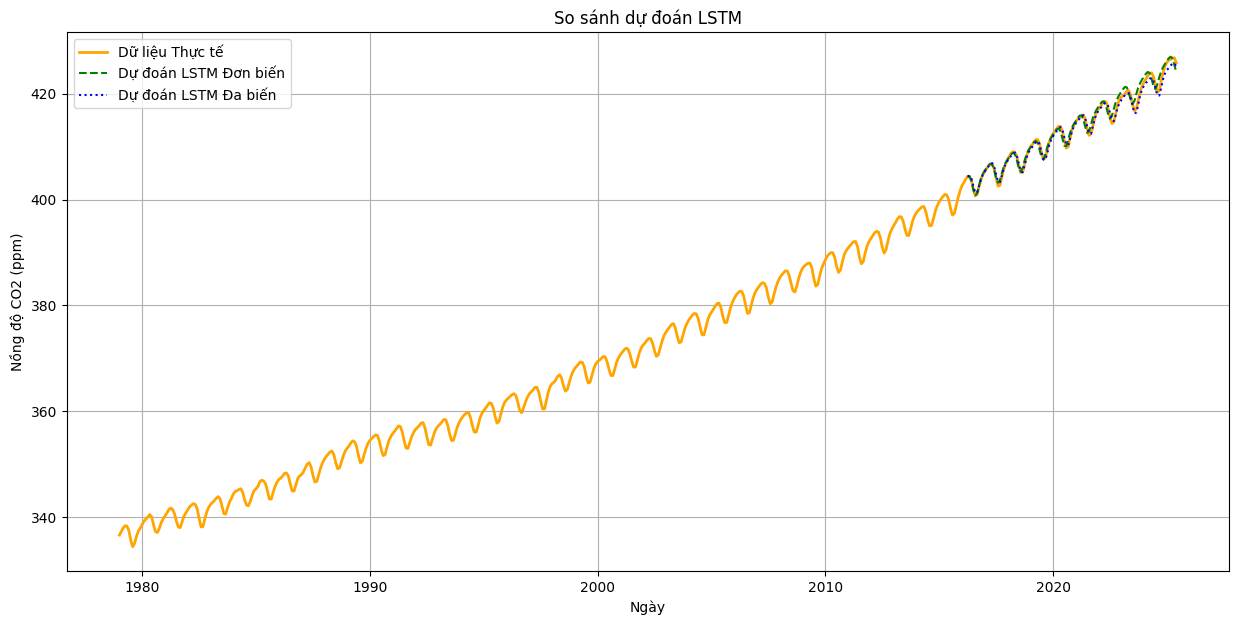

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(all_data['co2_ppm'], label='Dữ liệu Thực tế', color='orange', linewidth=2)
plt.plot(test_co2.index, predictions_uni_final, label='Dự đoán LSTM Đơn biến', color='green', linestyle='--')
plt.plot(test_co2.index, predictions_multi_final, label='Dự đoán LSTM Đa biến', color='blue', linestyle=':')
plt.title('So sánh dự đoán LSTM')
plt.xlabel('Ngày')
plt.ylabel('Nồng độ CO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Dự đoán nồng độ CO2 trong 24 tháng tới:
            co2_ppm_predicted
2025-07-01         429.047944
2025-08-01         428.592164
2025-09-01         427.872315
2025-10-01         428.253686
2025-11-01         429.256986
...
            co2_ppm_predicted
2027-02-01         433.441475
2027-03-01         433.966009
2027-04-01         434.486257
2027-05-01         434.662917
2027-06-01         434.033933


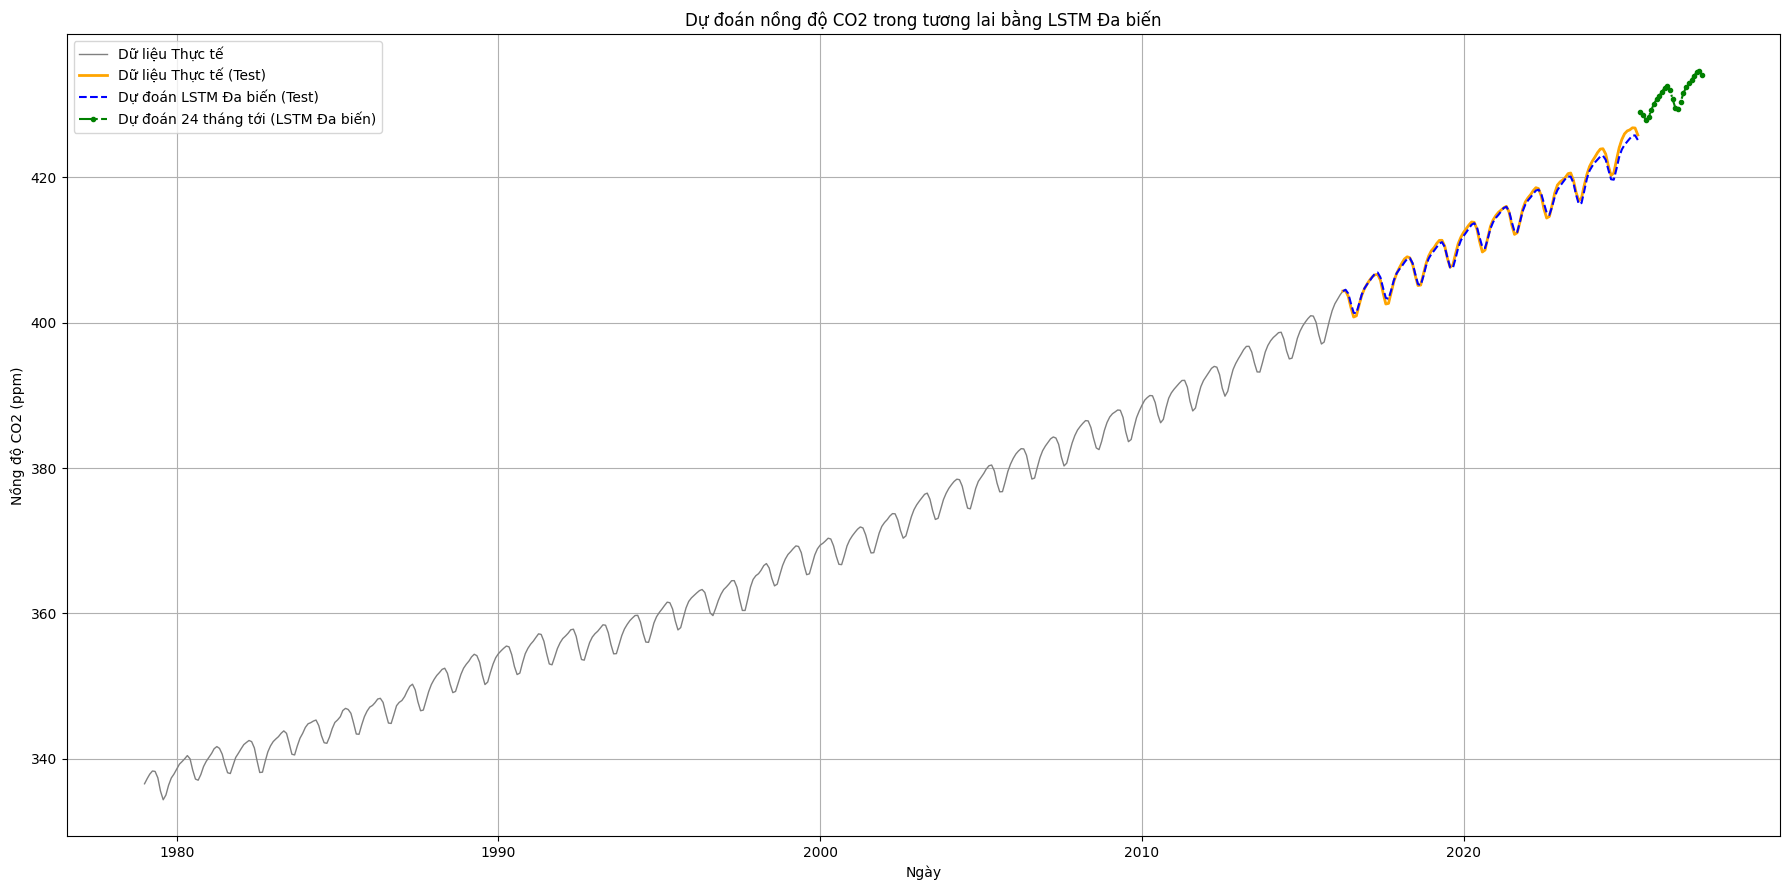

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

last_date = all_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='MS')


future_df = pd.DataFrame(index=future_dates)

future_df['soi'] = 0.0

future_df = add_seasonal_features(future_df)

future_exog = future_df[['soi', 'month_sin', 'month_cos']]

last_trend_index = all_data_featured['trend'].iloc[-1]
future_trend_indices = np.arange(last_trend_index + 1, last_trend_index + 1 + len(future_dates))
future_trend_forecast = lr_model.predict(future_trend_indices.reshape(-1, 1))

dummy_future_scaled_data = np.zeros((len(future_df), len(lstm_cols)))
dummy_future_scaled_data[:, 1:] = future_exog.values

future_exog_scaled = scaler.transform(dummy_future_scaled_data)[:, 1:]

predictions_scaled_future_detrended = recursive_forecast(
    model_multi,
    train_scaled,
    n_steps=len(future_dates),
    test_exog=future_exog_scaled
)

final_predictions_scaled_future = np.zeros((len(future_dates), len(lstm_cols)))
final_predictions_scaled_future[:, 0] = predictions_scaled_future_detrended
final_predictions_scaled_future[:, 1:] = future_exog_scaled

ziczac_forecast_future = scaler.inverse_transform(final_predictions_scaled_future)[:, 0]

final_co2_predictions = ziczac_forecast_future + future_trend_forecast

future_predictions_df = pd.DataFrame(final_co2_predictions, index=future_dates, columns=['co2_ppm_predicted'])

print("Dự đoán nồng độ CO2 trong 24 tháng tới:")
print(future_predictions_df.head())
print("...")
print(future_predictions_df.tail())

plt.figure(figsize=(18, 9))
plt.plot(all_data['co2_ppm'], label='Dữ liệu Thực tế ', color='gray', linewidth=1)
plt.plot(all_data.index[test_size:], test_df['co2_ppm'].values, label='Dữ liệu Thực tế (Test)', color='orange', linewidth=2)
plt.plot(test_co2.index, predictions_multi_final, label='Dự đoán LSTM Đa biến (Test)', color='blue', linestyle='--')
plt.plot(future_predictions_df.index, future_predictions_df['co2_ppm_predicted'], label='Dự đoán 24 tháng tới (LSTM Đa biến)', color='green', linestyle='-.', marker='o', markersize=3)

plt.title('Dự đoán nồng độ CO2 trong tương lai bằng LSTM Đa biến')
plt.xlabel('Ngày')
plt.ylabel('Nồng độ CO2 (ppm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
future_predictions_df

,co2_ppm_predicted
2025-07-01,429.047944
2025-08-01,428.592164
2025-09-01,427.872315
2025-10-01,428.253686
2025-11-01,429.256986
2025-12-01,430.116730
2026-01-01,430.747175
2026-02-01,431.249534
2026-03-01,431.771218
2026-04-01,432.316986
